<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/5_5_Extract_computer_vision_representations_of_pokemons_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install kaggle API in colab

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

# since I uploaded my kaggle credential to google drive, I need to get it from there

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# after copy and paste a "code" to the box in the cell above, you have access to my google drive

In [0]:
kaggle_id = 'https://drive.google.com/open?id=1V9NdDvApsDGxl5Rl-JWYmSTmFvTNSOkC'.split('id=')[-1]
downloaded = drive.CreateFile({'id':kaggle_id})
downloaded.GetContentFile(f'kaggle.json')

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list

ref                                                     title                                              size  lastUpdated          downloadCount  
------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
chicago/chicago-copa-cases                              Chicago COPA Cases                                  3MB  2019-04-05 00:00:32           1299  
himanshupoddar/zomato-bangalore-restaurants             Zomato Bangalore Restaurants                       88MB  2019-03-31 09:48:43           1557  
sfinspiredu/synchrotron-data-set                        Synchrotron Data Set                               10KB  2019-05-27 19:54:29            257  
crisparada/brazilian-cities                             Brazilian Cities                                  935KB  2019-05-24 20:49:21            827  
taniaj/australian-election-2019-tweets                  Australian Election 2019 Tweets             

# download the pokemon images

In [0]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset
!ls

complete-pokemon-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
adc.json			complete-pokemon-image-dataset.zip  sample_data
complete-pokemon-image-dataset	kaggle.json


# upzip the files

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('complete-pokemon-image-dataset.zip', 'r')
zip_ref.extractall('complete-pokemon-image-dataset')
zip_ref.close()

!ls

adc.json			complete-pokemon-image-dataset.zip  sample_data
complete-pokemon-image-dataset	kaggle.json


# import python libraries

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
from tensorflow.keras import layers,applications,preprocessing,models
import numpy as np
import pandas as pd

In [0]:
image_size = 128
batch_size = 32

# download the computer vision model you like

In [0]:
feature_model = applications.VGG19(include_top = False, 
                                   weights = 'imagenet', 
                                   input_tensor = None, 
                                   input_shape = (image_size,image_size,3), 
                                   pooling = 'avg', 
                                   classes = 1000,
                                  )
feature_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

# define a data generating pipeline:

## preprocess the image from the folder
## have the image ready for the model in batch size

In [0]:
generator = preprocessing.image.ImageDataGenerator(featurewise_center=False, 
                                                   samplewise_center=False, 
                                                   featurewise_std_normalization=False, 
                                                   samplewise_std_normalization=False, 
                                                   zca_whitening=False, 
                                                   zca_epsilon=1e-06, 
                                                   rotation_range=0, 
                                                   width_shift_range=0.0, 
                                                   height_shift_range=0.0, 
                                                   brightness_range=None, 
                                                   shear_range=0.0, 
                                                   zoom_range=0.0, 
                                                   channel_shift_range=0.0, 
                                                   fill_mode='nearest', 
                                                   cval=0.0, 
                                                   horizontal_flip=False, 
                                                   vertical_flip=False, 
                                                   rescale=1./255,  ##########
                                                   preprocessing_function=None, 
                                                   data_format=None, 
                                                   validation_split=0.0, 
                                                   dtype=None)
datagen = generator.flow_from_directory("complete-pokemon-image-dataset",
                                        target_size = (image_size, image_size),
                                        batch_size = batch_size,
                                        shuffle = False)

Found 24646 images belonging to 928 classes.


# if we don't want to fine tune the computer vision model particularly for the data, we can just pass the images through the model and get the outputs of the images, and those are the "representations" of the computer vision model

In [0]:
filenames = datagen.filenames
nb_samples = len(filenames)
features = feature_model.predict_generator(datagen,steps = np.ceil(nb_samples / batch_size),max_queue_size = 1,verbose = 1)

771/771 [==============================] - 58s 76ms/step


In [0]:
features.shape

(24646, 512)

In [0]:
df = pd.DataFrame(features,)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.305575,0.0,0.002027,0.108844,0.328289,0.023287,0.000000,0.000000,0.025354,0.170517,0.0,0.0000,0.038614,0.0,0.000000,0.929525,0.010465,0.135323,0.000701,0.00313,0.086107,0.000000,0.0,0.208952,0.361112,0.0,0.551976,0.209187,0.366030,0.088423,0.487428,0.531855,0.000457,0.667551,0.005699,0.0,0.678114,0.000000,0.007524,0.0,...,0.521598,0.000000,1.116850,0.047326,0.0,0.025783,0.125080,0.0,0.100726,0.000000,0.245632,0.0,0.00000,0.000000,0.069231,0.037147,0.734569,0.000000,0.281599,0.449126,0.042316,0.0,0.090132,0.221470,0.206368,0.000191,0.223736,0.439289,0.439394,0.071476,1.297379,0.059576,0.022501,0.062952,0.000000,0.485358,0.014292,0.000000,0.670480,0.0
1,0.236229,0.0,0.238358,0.000000,0.293672,0.000000,0.008278,0.009915,0.000000,0.021877,0.0,0.0000,0.056119,0.0,0.000000,0.198088,0.000000,0.199896,0.009969,0.00000,0.000000,0.000000,0.0,0.184439,0.000000,0.0,0.276154,0.167836,0.733991,0.000000,0.554073,0.391678,0.016212,0.000000,0.028854,0.0,0.000000,0.000000,0.000000,0.0,...,0.205136,0.000000,1.242072,0.000000,0.0,0.395052,0.024143,0.0,0.187274,0.003616,0.682933,0.0,0.00000,0.000000,0.187441,0.000000,0.058264,0.046048,0.037883,0.162280,0.021387,0.0,0.775824,0.072492,0.171459,0.021345,0.254834,0.425626,0.061195,0.000000,1.108880,0.010103,0.250052,0.006010,0.059546,0.215631,0.000000,0.000000,0.675061,0.0
2,0.308911,0.0,0.374550,0.003902,0.166137,0.003632,0.000000,0.017129,0.000000,0.000000,0.0,0.0000,0.223774,0.0,0.012202,0.768774,0.020354,0.254404,0.000000,0.00000,0.000000,0.000000,0.0,0.006570,0.000000,0.0,0.814347,0.251453,0.702971,0.000000,0.646707,0.284934,0.220978,0.000000,0.030872,0.0,0.056613,0.007285,0.000000,0.0,...,0.139011,0.012693,1.576492,0.034257,0.0,0.382388,0.030329,0.0,0.232333,0.209994,0.611636,0.0,0.00000,0.013861,0.084864,0.000000,0.070196,0.037082,0.000000,0.034534,0.196227,0.0,0.988435,0.241571,0.390767,0.334022,0.205405,0.631389,0.055674,0.000000,1.113921,0.008376,0.460339,0.028578,0.093824,0.369765,0.016289,0.000000,0.834060,0.0
3,1.131144,0.0,0.331394,0.000000,0.810730,0.000000,0.005862,0.037031,0.165903,0.050081,0.0,0.0033,0.237983,0.0,0.000000,0.552178,0.098701,0.172882,0.074429,0.00000,0.008292,0.029959,0.0,0.263722,0.142716,0.0,0.128056,0.227148,0.454263,0.000000,0.590476,0.832629,0.246396,0.099120,0.040442,0.0,0.459336,0.009085,0.000000,0.0,...,0.365724,0.011685,1.041216,0.000000,0.0,0.579950,0.000000,0.0,0.052538,0.000000,0.303927,0.0,0.00826,0.185310,0.108097,0.000000,0.291998,0.000000,0.168753,0.435970,0.096442,0.0,0.067045,0.044498,0.212191,0.140031,0.062106,0.226974,0.307235,0.000000,0.843356,0.066732,0.558657,0.113992,0.433280,0.625764,0.012418,0.000000,0.600099,0.0
4,0.707578,0.0,0.288148,0.043202,1.225873,0.000000,0.025960,0.004154,0.009166,0.040792,0.0,0.0000,0.132109,0.0,0.000000,0.470345,0.447595,0.308375,0.000000,0.00000,0.033372,0.016843,0.0,0.178457,0.000000,0.0,0.352539,0.310200,0.701327,0.006579,0.516074,1.059597,0.106773,0.221053,0.084549,0.0,0.528825,0.078557,0.000000,0.0,...,0.662704,0.000000,0.951108,0.000000,0.0,0.053011,0.074599,0.0,0.005455,0.000000,0.915747,0.0,0.00000,0.000000,0.071477,0.000000,0.149967,0.052688,0.260158,0.198085,0.000000,0.0,0.547857,0.050406,0.771059,0.076916,0.006042,0.275042,0.876091,0.033026,0.974861,0.027653,0.161078,0.036250,0.086268,0.299698,0.000000,0.007316,0.775468,0.0


In [0]:
df.columns = [f'feature_{idx}' for idx in range(df.shape[1])]

In [0]:
df['pokemon_name'] = [filename.split('/')[0] for filename in filenames]

In [0]:
df_averaged = df.groupby(['pokemon_name']).mean().reset_index(drop = False)
df_averaged.head()

,pokemon_name,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_472,feature_473,feature_474,feature_475,feature_476,feature_477,feature_478,feature_479,feature_480,feature_481,feature_482,feature_483,feature_484,feature_485,feature_486,feature_487,feature_488,feature_489,feature_490,feature_491,feature_492,feature_493,feature_494,feature_495,feature_496,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511
0,Abomasnow,0.426644,0.000000,0.385236,0.027931,0.486543,0.005065,0.024109,0.027960,0.028587,0.041996,0.006597,0.000132,0.179443,0.000000,0.004666,0.410943,0.079018,0.255630,0.009101,0.007775,0.016686,0.022684,0.002884,0.165853,0.034274,0.000749,0.402122,0.221470,0.475550,0.011712,0.502747,0.494429,0.167642,0.089668,0.033141,0.000000,0.153599,0.014794,0.000301,...,0.364313,0.004125,1.209722,0.009610,0.000000,0.234575,0.032188,0.0000,0.152897,0.053691,0.562802,0.002067,0.000384,0.047470,0.167598,0.013197,0.175695,0.026190,0.123079,0.234677,0.076528,0.002608,0.674988,0.103139,0.366081,0.102055,0.149977,0.489022,0.333557,0.009423,1.211527,0.037862,0.344145,0.052351,0.110595,0.304796,0.019052,0.005513,0.764238,0.000805
1,Abomasnow(Mega),0.368768,0.000000,0.456626,0.028136,0.456154,0.001859,0.019179,0.061396,0.006284,0.020038,0.001195,0.000000,0.234826,0.000000,0.000201,0.343556,0.056757,0.215680,0.005959,0.000000,0.000000,0.010679,0.000000,0.148863,0.006068,0.000076,0.270698,0.235390,0.375062,0.008264,0.399683,0.574548,0.199060,0.036125,0.051598,0.000111,0.096955,0.027971,0.000000,...,0.312571,0.005829,0.930378,0.001123,0.004003,0.185736,0.019503,0.0013,0.184577,0.015847,0.561109,0.006562,0.000000,0.044955,0.247867,0.003838,0.095623,0.018208,0.127213,0.208125,0.044897,0.002413,0.750693,0.039949,0.413109,0.035026,0.154275,0.417503,0.357518,0.003935,1.307174,0.054354,0.456080,0.033571,0.127489,0.258224,0.024264,0.002318,0.797610,0.000446
2,Abra,0.376925,0.000000,0.287023,0.012523,0.353593,0.004331,0.080796,0.027263,0.011775,0.159274,0.022411,0.000009,0.224367,0.002286,0.028764,0.385147,0.110707,0.256541,0.007034,0.008782,0.002760,0.030330,0.000485,0.223935,0.022650,0.013645,0.467104,0.283760,0.422968,0.005475,0.582631,0.129232,0.231612,0.033335,0.020507,0.000792,0.058190,0.038811,0.000106,...,0.405882,0.000154,1.375654,0.004951,0.000000,0.135145,0.054956,0.0000,0.242353,0.093100,0.576065,0.003995,0.000000,0.015082,0.197933,0.060655,0.138239,0.035366,0.058535,0.298075,0.079577,0.005016,0.815222,0.137061,0.245819,0.132334,0.273746,0.729342,0.224475,0.003388,1.497956,0.042557,0.226352,0.051081,0.069397,0.275962,0.012469,0.025775,0.737919,0.000804
3,Absol,0.214860,0.001166,0.320798,0.073446,0.580271,0.024735,0.037178,0.039360,0.068623,0.059813,0.007053,0.000369,0.222321,0.000735,0.136080,0.251923,0.044775,0.304120,0.007105,0.000313,0.001074,0.027430,0.004688,0.123048,0.005262,0.000000,0.697081,0.198527,0.270608,0.013499,0.816293,0.377938,0.201324,0.023377,0.035815,0.000000,0.048390,0.024274,0.004908,...,0.337652,0.068846,1.276607,0.004239,0.000251,0.219579,0.071499,0.0000,0.241808,0.055689,0.658197,0.007128,0.000000,0.053820,0.143761,0.002683,0.096556,0.061752,0.257323,0.192194,0.306247,0.001482,1.015333,0.056411,0.308894,0.261163,0.191914,0.711698,0.249056,0.000000,1.293302,0.053846,0.384524,0.040141,0.055513,0.361747,0.051688,0.007253,0.851693,0.001368
4,Absol(Mega),0.246390,0.000000,0.347256,0.034860,0.489664,0.001850,0.024135,0.019628,0.133933,0.030801,0.001389,0.000000,0.217943,0.001739,0.002557,0.300233,0.070675,0.230949,0.015180,0

In [0]:
import seaborn as sns
from scipy.spatial.distance import pdist,squareform
from matplotlib import pyplot as plt

In [0]:
df_plot = df_averaged[[col for col in df_averaged.columns if ("feature" in col)]]
C = df_plot.values - df_plot.values.mean(0)

In [0]:
rdm = squareform(pdist(C,metric = 'cosine'))

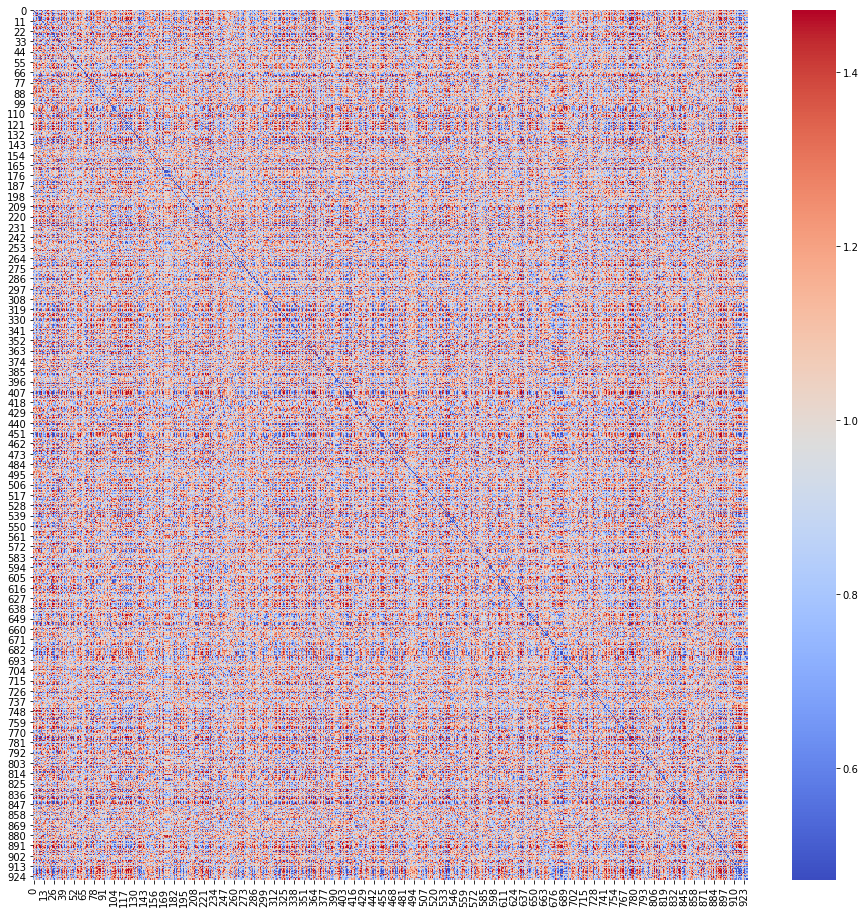

In [0]:
fig, ax = plt.subplots(figsize = (16,16))
sns.heatmap(rdm,cmap = plt.cm.coolwarm,robust = True,ax=ax)